<a href="https://colab.research.google.com/github/oopsys6/Algorithm/blob/master/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch Data Augmentation

인기 있는 데이터셋의 경우 수천 수만장의 이미지를 가지고 있습니다. 하지만 모든 데이터셋이 그렇진 못합니다.  그러면 제한된 데이터셋을 학습 시키기 위해서는 어떻게 해결 해야 할까요?

우리는 데이터셋이 부족하다고 새로운 이미지를 찾을 필요가 없습니다. 왜냐하면 Data Augmentation을 이용하여 다양한 상태의 이미지를 얻을 수 있기 때문입니다.

![](https://drive.google.com/uc?id=1ammM-EnG9aCvMsLvpm-P-6UvOz56M9P3)
- 그림 3.1 같아 보이지만 다른 테니스 공 (출처:https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/)

그림 3.1은 사람이 보기엔 다 똑같은 테니스 공입니다. 하지만 신경망은 3개의 테니스 공을 다 다르게 봅니다. 이와 같은 원리로 우리는 하나의 사진을 변조 시켜 여러 개의 데이터를 추출해낼 수 있습니다.

Augmentation를 처리하기 위해서 Albumentations를 사용해 볼 것입니다. Albumentations는 OpenCV와 같은 오픈 소스 컴퓨터 비젼 라이브러리를 최적화 하였기에 다른 image argumentation 라이브러리보다 더 빠른 처리 속도를 보여주고 다양한 기능도 제공합니다. 

우선 많이 사용하는 pytorchvison.transforms와 albumentations을 비교하여 albumentations가 얼마나 빠른지에 대해 알아봅시다.




In [1]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt

from google.colab import drive

In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
class TorchvisionDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with PIL
        image = Image.open(file_path)
        
        start_t = time.time()
        if self.transform:
            image = self.transform(image)
        total_time = (time.time() - start_t)

        return image, label, total_time

In [4]:
torchvision_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionDataset(
    file_paths=["/content/gdrive/My Drive/rabbit.jpg"],
    labels=[1],
    transform=torchvision_transform,
)

In [5]:
torchvision_transform

Compose(
    Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

torchvision time/sample: 58.54572534561157 ms


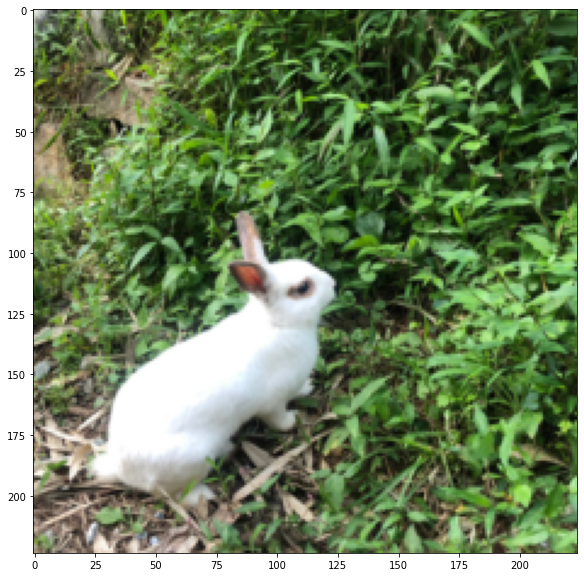

In [7]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time/sample: {} ms".format(total_time*10))

plt.figure(figsize=(10, 10))
plt.imshow(transforms.ToPILImage()(sample))
plt.show()

In [8]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            total_time = (time.time() - start_t)
        return image, label, total_time

In [9]:
# Same transform with torchvision_transform
albumentations_transform = albumentations.Compose([
    albumentations.Resize(256, 256), 
    albumentations.RandomCrop(224, 224),
    albumentations.HorizontalFlip(), # Same with transforms.RandomHorizontalFlip()
    albumentations.pytorch.transforms.ToTensor()
])

albumentations time/sample: 2.514803409576416 ms


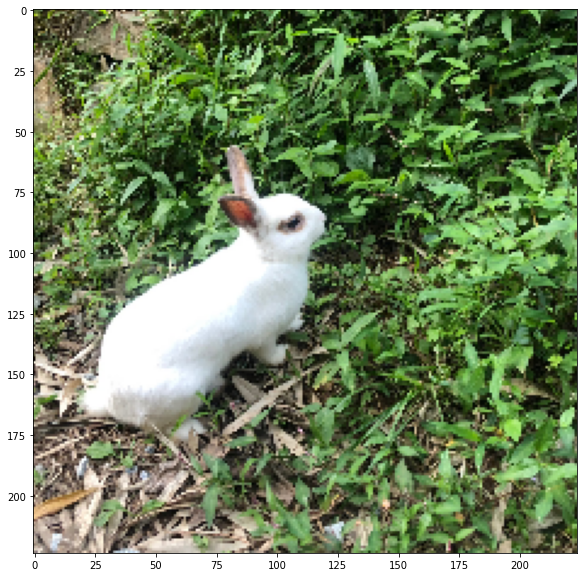

In [10]:
# Same dataset with torchvision_dataset
albumentations_dataset = AlbumentationsDataset(
    file_paths=["/content/gdrive/My Drive/rabbit.jpg"],
    labels=[1],
    transform=albumentations_transform,
)
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentations_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

plt.figure(figsize=(10, 10))
plt.imshow(transforms.ToPILImage()(sample))
plt.show()